### Churn Prediction

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [2]:
data = pd.read_csv("data.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
data.shape

(7043, 21)

In [4]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [6]:
columns = data.columns
for col in columns:
    print("Column: ", col)
    print(data[col].value_counts(dropna=False))
    print()

Column:  customerID
2706-QZIHY    1
0168-XZKBB    1
1174-FGIFN    1
0256-LTHVJ    1
3372-KWFBM    1
             ..
8410-BGQXN    1
0557-ASKVU    1
3404-JNXAX    1
1265-BCFEO    1
2483-XSSMZ    1
Name: customerID, Length: 7043, dtype: int64

Column:  gender
Male      3555
Female    3488
Name: gender, dtype: int64

Column:  SeniorCitizen
0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Column:  Partner
No     3641
Yes    3402
Name: Partner, dtype: int64

Column:  Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64

Column:  tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64

Column:  PhoneService
Yes    6361
No      682
Name: PhoneService, dtype: int64

Column:  MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

Column:  InternetService
Fiber optic    3096
DSL            2421
No             1

In [7]:
def strToNum(df, column):
    mapping = {'Yes': 1, 'No': 0}
    df[column] = df[column].map(mapping)

cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in cols:
    strToNum(data, col)

In [8]:
data.rename({'InternetService': 'InternetServiceType'}, axis=1, inplace=True)

In [9]:
data['InternetService'] = data['InternetServiceType'].map({'No': 0, 'Fiber optic': 1, 'DSL': 1})

In [10]:
data.loc[data['TotalCharges'] == ' ', 'TotalCharges'] = '0'
data['TotalCharges'] = data['TotalCharges'].astype('float64')

In [11]:
data.dtypes

customerID              object
gender                  object
SeniorCitizen            int64
Partner                  int64
Dependents               int64
tenure                   int64
PhoneService             int64
MultipleLines           object
InternetServiceType     object
OnlineSecurity          object
OnlineBackup            object
DeviceProtection        object
TechSupport             object
StreamingTV             object
StreamingMovies         object
Contract                object
PaperlessBilling         int64
PaymentMethod           object
MonthlyCharges         float64
TotalCharges           float64
Churn                    int64
InternetService          int64
dtype: object

In [12]:
# Checking for missing data
num_rows = data.shape[0]
num_missing = num_rows - data.count()
num_missing

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
tenure                 0
PhoneService           0
MultipleLines          0
InternetServiceType    0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
Contract               0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn                  0
InternetService        0
dtype: int64

In [13]:
columns = data.columns.tolist()
columns.remove('Churn')
columns.remove('customerID')
X = data[columns]
y = data['Churn']

In [14]:
X = pd.get_dummies(X, drop_first=True)

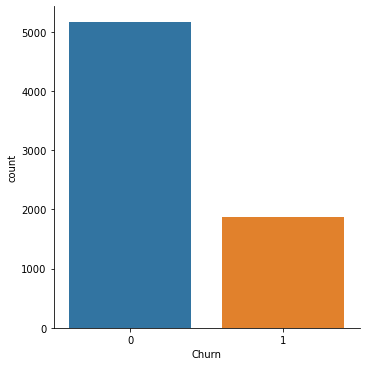

In [15]:
# Imbalanced
sns.catplot(x='Churn', data=data, kind='count');

In [16]:
X['MonthlyCharges'] = scale(X['MonthlyCharges'])
X['TotalCharges'] = scale(X['TotalCharges'])
X['tenure'] = scale(X['tenure'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [19]:
X_train.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService,gender_Male,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2526,0,0,0,-1.277445,1,0,-1.507638,-0.997221,0,1,...,0,1,0,1,0,0,0,0,0,1
4843,0,1,1,1.491540,1,0,-1.481050,-0.398492,0,1,...,0,1,0,1,0,0,1,0,0,0
4522,0,1,0,-0.096554,1,0,-1.464432,-0.746761,0,1,...,0,1,0,1,0,1,0,1,0,0
4777,0,0,1,-1.236724,1,0,-0.439103,-0.958926,1,0,...,0,0,0,0,0,0,0,0,0,1
5880,0,0,0,-1.196004,0,1,-1.168632,-0.970728,1,1,...,0,0,0,0,0,0,0,0,1,0


In [20]:
under = RandomUnderSampler(sampling_strategy=0.7)
over = SMOTE()

In [21]:
rfc = RandomForestClassifier(n_estimators=500)
steps = [('under', under), ('over', over), ('rfc', rfc)]
pipeline_rfc = Pipeline(steps=steps)

In [22]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
scores = cross_val_score(pipeline_rfc, X_train, y_train, scoring='roc_auc', cv=cv)
scores.mean()

0.8272794067860721

In [23]:
svc = SVC(probability=True)
steps = [('under', under), ('over', over), ('svc', svc)]
pipeline_svc = Pipeline(steps=steps)

In [24]:
cv2 = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
scores_svc = cross_val_score(pipeline_svc, X_train, y_train, scoring='roc_auc', cv=cv2)
scores_svc.mean()

0.8255925156296133

In [25]:
lr = LogisticRegression(max_iter=200)

In [26]:
cv3 = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
scores_lr = cross_val_score(lr, X_train, y_train, scoring='roc_auc', cv=cv3)
scores_lr.mean()

0.8437520536863556

In [46]:
models = [{
        'label': 'Logistic Regression',
        'model': lr,
    }, {
        'label': 'Random Forest',
        'model': pipeline_rfc,
    }, {
        'label': 'SVM',
        'model': pipeline_svc,
    }
]

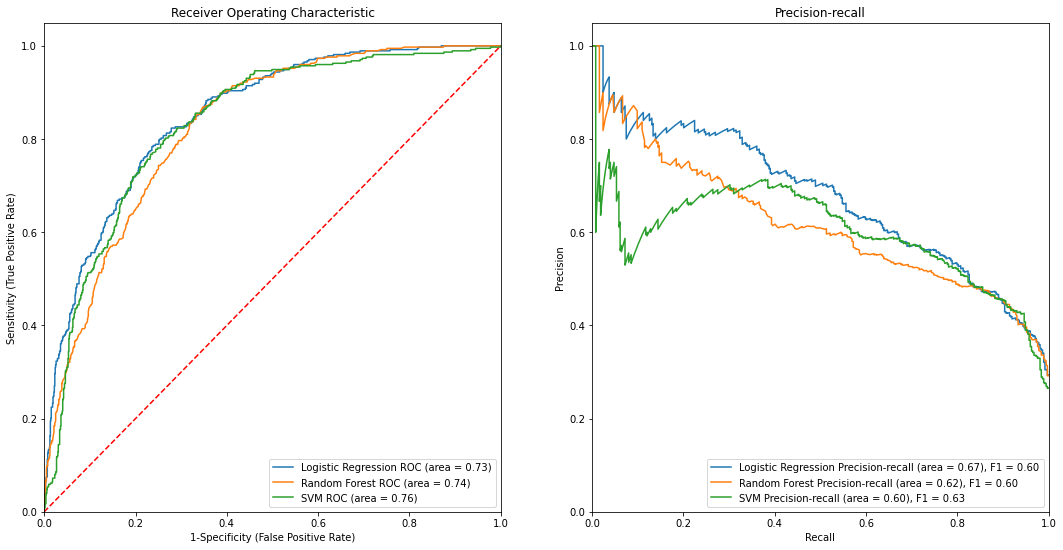

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

for m in models:
    model = m['model'] 
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)

    # ROC
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc_score = roc_auc_score(y_test,model.predict(X_test))
    ax1.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc_score))
    
    # Precision-recall
    precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
    auc_score = auc(recall, precision)
    f1 = f1_score(y_test, y_pred)
    ax2.plot(recall, precision, label='%s Precision-recall (area = %0.2f), F1 = %0.2f' % (m['label'], auc_score, f1))
    
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('1-Specificity (False Positive Rate)')
ax1.set_ylabel('Sensitivity (True Positive Rate)')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right")

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-recall')
ax2.legend(loc="lower right")